In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats as st
import itertools as it
from tqdm import tqdm_notebook as tqdm
from matplotlib.animation import FuncAnimation
import random,os
import multiprocessing as mp
import modelutils
plt.ion()

In [2]:
npeople=50
ndays=14
ntrials=50
lambda_=3e-2
testdelay=1
testsperday=5
locations=['Broad','Moore','Watson','Beckman','Noyes','Braun','Schlinger','Kerckhoff','Spalding','Chandler']

### Main Simulation

In [3]:
agent_states_policy0_trials = np.zeros(shape=[ntrials,ndays,11,npeople])
agent_states_policy1_trials = np.zeros(shape=[ntrials,ndays,11,npeople])

init_state = modelutils.gen_initstate(N=npeople,statefreqs=[0.4,0.3,0.2]+6*[0.1/6]+[0,0])

def simulation_policy0(x):
    agent_locations,agent_states = modelutils.run_simulation(ndays,npeople,locations,init_states=init_state,testsperday=testsperday,testingpolicy='Random',lambda_=lambda_,testdelay=testdelay)
    return agent_states

def simulation_policy1(x):
    agent_locations,agent_states = modelutils.run_simulation(ndays,npeople,locations,init_states=init_state,testsperday=testsperday,testingpolicy='Greedy',lambda_=lambda_,testdelay=testdelay)
    return agent_states

with mp.Pool(processes=6) as pool:
    agent_states_policy0_trials= pool.map(simulation_policy0,np.arange(ntrials))
    agent_states_policy1_trials = pool.map(simulation_policy1,np.arange(ntrials))
    
agent_states_policy0_trials = np.concatenate([np.expand_dims(x,axis=0) for x in agent_states_policy0_trials],axis=0)
agent_states_policy1_trials = np.concatenate([np.expand_dims(x,axis=0) for x in agent_states_policy1_trials],axis=0)
os.system('say "Simulation finished"')

0

In [4]:
agent_states_policy0_trials_sum = np.sum(agent_states_policy0_trials,axis=-1)/npeople
agent_states_policy1_trials_sum = np.sum(agent_states_policy1_trials,axis=-1)/npeople



agent_states_policy0_trials_reduced = np.zeros([ntrials,ndays,5])
agent_states_policy1_trials_reduced = np.zeros([ntrials,ndays,5])

for seir_idx in range(5):
    agent_states_policy0_trials_reduced[:,:,0] =np.sum(agent_states_policy0_trials_sum[:,:,0:3],axis=-1)
    agent_states_policy0_trials_reduced[:,:,1] = np.sum(agent_states_policy0_trials_sum[:,:,3:6],axis=-1)
    agent_states_policy0_trials_reduced[:,:,2] = np.sum(agent_states_policy0_trials_sum[:,:,6:9],axis=-1)
    agent_states_policy0_trials_reduced[:,:,3] = agent_states_policy0_trials_sum[:,:,9]
    agent_states_policy0_trials_reduced[:,:,4] = agent_states_policy0_trials_sum[:,:,10]
    
    agent_states_policy1_trials_reduced[:,:,0] =np.sum(agent_states_policy1_trials_sum[:,:,0:3],axis=-1)
    agent_states_policy1_trials_reduced[:,:,1] = np.sum(agent_states_policy1_trials_sum[:,:,3:6],axis=-1)
    agent_states_policy1_trials_reduced[:,:,2] = np.sum(agent_states_policy1_trials_sum[:,:,6:9],axis=-1)
    agent_states_policy1_trials_reduced[:,:,3] = agent_states_policy1_trials_sum[:,:,9]
    agent_states_policy1_trials_reduced[:,:,4] = agent_states_policy1_trials_sum[:,:,10]

    
percentiles = [10,30,90,70]
agent_states_policy0_percentiles = np.zeros([len(percentiles),ndays,5])
agent_states_policy1_percentiles = np.zeros([len(percentiles),ndays,5])

for p_idx in range(len(percentiles)):
    agent_states_policy0_percentiles[p_idx,...]=np.percentile(agent_states_policy0_trials_reduced,percentiles[p_idx],axis=0)
    agent_states_policy1_percentiles[p_idx,...]=np.percentile(agent_states_policy1_trials_reduced,percentiles[p_idx],axis=0)


Visualization code below...

Text(0, 0.5, 'Fraction')

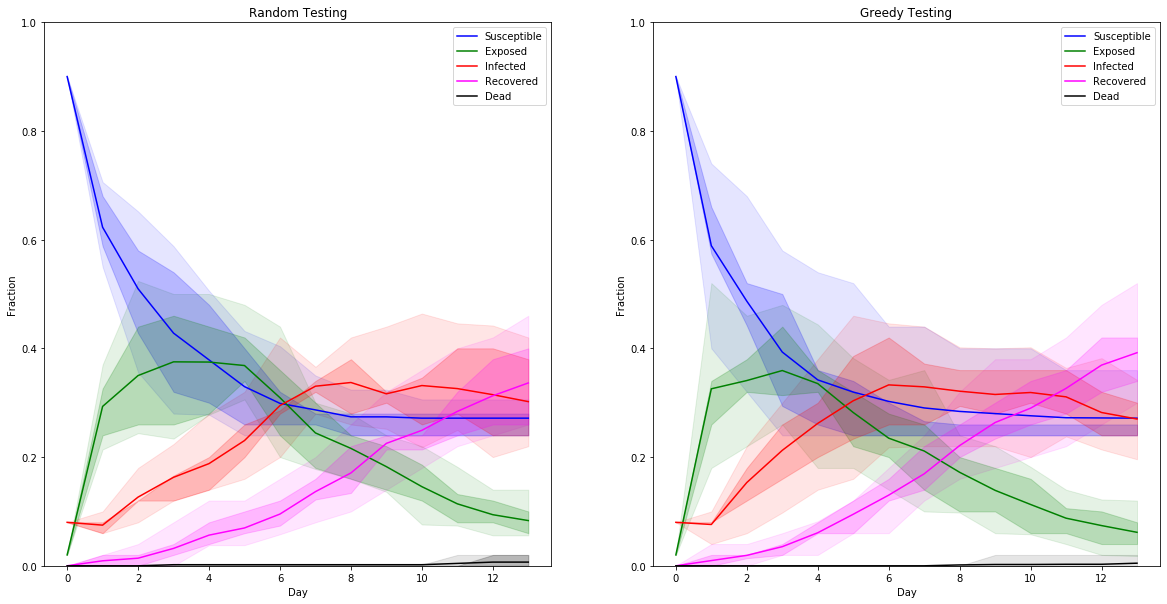

In [5]:
alphalist = np.linspace(0.1,.3,3)
colorlist = ['blue','green','red','magenta','black']
time = np.arange(ndays)

fig,ax = plt.subplots(ncols=2,figsize=[20,10])

for plot_idx in range(len(percentiles)//2):
    for seir_idx in range(5):
        ax[0].fill_between(time,agent_states_policy0_percentiles[plot_idx,:,seir_idx],agent_states_policy0_percentiles[plot_idx+2,:,seir_idx],color=colorlist[seir_idx],alpha=alphalist[plot_idx])
        ax[1].fill_between(time,agent_states_policy1_percentiles[plot_idx,:,seir_idx],agent_states_policy1_percentiles[plot_idx+2,:,seir_idx],color=colorlist[seir_idx],alpha=alphalist[plot_idx])
        
        if plot_idx==1:
            ax[0].plot(time,np.mean(agent_states_policy0_trials_reduced[:,:,seir_idx],axis=0),color=colorlist[seir_idx])        
            ax[1].plot(time,np.mean(agent_states_policy1_trials_reduced[:,:,seir_idx],axis=0),color=colorlist[seir_idx])  
ax[0].legend(['Susceptible','Exposed','Infected','Recovered','Dead'])
ax[1].legend(['Susceptible','Exposed','Infected','Recovered','Dead'])
ax[0].set_title('Random Testing')
ax[1].set_title('Greedy Testing')
ax[0].set_xlabel('Day')
ax[1].set_xlabel('Day')
ax[0].set_ylim([0,1])
ax[1].set_ylim([0,1])
ax[0].set_ylabel('Fraction')
ax[1].set_ylabel('Fraction')
#plt.savefig('testing_policy_simulation.png')

In [6]:
# means_policy0 = np.mean(agent_states_policy0_trials_reduced[...],axis=0)       
# means_policy1 = np.mean(agent_states_policy1_trials_reduced[...],axis=0)

# diffs = means_policy1 - means_policy0
# fig,ax = plt.subplots(figsize=(10,10))


# for plot_idx in range(5):
#     ax.plot(time,diffs[:,plot_idx],color=colorlist[plot_idx])
# ax.legend(['Susceptible','Exposed','Infected','Recovered','Dead'])
# ax.set_ylabel('Delta Fraction (Chandler - Dorm)')
# ax.set_xlabel('Day')
# ax.set_title('Difference in SEIRD Between Policies')

Text(0.5, 1.0, 'Differences in Outcomes Between Policies')

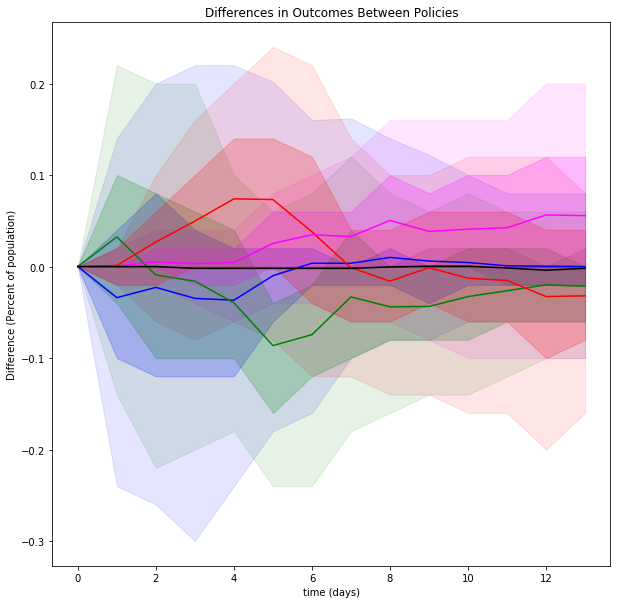

In [7]:
bootstrapped_differences = np.zeros([ntrials**2,ndays,11])
for idx1 in range(ntrials):
    for idx2 in range(ntrials):
        bootstrapped_differences[ntrials*(idx1)+idx2,...] = agent_states_policy1_trials_sum[idx2,...]-agent_states_policy0_trials_sum[idx1,...]

        
        
bootstrap_reduced = np.zeros([ntrials**2,ndays,5])
for seir_idx in range(5):
    bootstrap_reduced[:,:,0] =np.sum(bootstrapped_differences[:,:,0:3],axis=-1)
    bootstrap_reduced[:,:,1] = np.sum(bootstrapped_differences[:,:,3:6],axis=-1)
    bootstrap_reduced[:,:,2] = np.sum(bootstrapped_differences[:,:,6:9],axis=-1)
    bootstrap_reduced[:,:,3] = bootstrapped_differences[:,:,9]
    bootstrap_reduced[:,:,4] = bootstrapped_differences[:,:,10]
    

    
    
    
bootstrap_percentiles = np.zeros([len(percentiles),ndays,5])

for p_idx in range(len(percentiles)):
    bootstrap_percentiles[p_idx,...]=np.percentile(bootstrap_reduced,percentiles[p_idx],axis=0)
    
    
    
fig,ax = plt.subplots(figsize=[10,10])
for plot_idx in range(len(percentiles)//2):
    for seir_idx in range(5):
        ax.fill_between(time,bootstrap_percentiles[plot_idx,:,seir_idx],bootstrap_percentiles[plot_idx+2,:,seir_idx],color=colorlist[seir_idx],alpha=alphalist[plot_idx])
        
        if plot_idx==1:
            ax.plot(time,np.mean(bootstrap_reduced[:,:,seir_idx],axis=0),color=colorlist[seir_idx])  
ax.set_xlabel('time (days)')
ax.set_ylabel('Difference (Percent of population)')
ax.set_title('Differences in Outcomes Between Policies')

In [8]:
# agent_locations_policy1,agent_states_policy1 = modelutils.run_simulation(ndays,npeople,locations,testsperday=testsperday,testingpolicy='Greedy',lambda_=lambda_,testdelay=testdelay)

Movement visualization below

In [9]:
# ndays=7
# print('Running Simulation...')
# agent_locations_policy0,agent_states_policy0 = modelutils.run_simulation(ndays,npeople,locations,testsperday=testsperday,testingpolicy='Random',lambda_=lambda_,testdelay=testdelay)
# agent_locations_policy1,agent_states_policy1 = modelutils.run_simulation(ndays,npeople,locations,testsperday=testsperday,testingpolicy='Greedy',lambda_=lambda_,testdelay=testdelay)
# #UNCOMMENT FOR MOVEMENT DEMO
# print("Finished!")

# ############################################################################


# def num2titlestr(n):
#     day = n//96
#     day_rem = n % 96
#     hours = day_rem // 12
    
#     fmt_hours = 9 + hours
#     if fmt_hours>12:
#         fmt_hours+=-12
#     fmt_hours= str(fmt_hours)
#     if len(fmt_hours)!=2:
#         fmt_hours = '0'+fmt_hours
    
#     hour_rem = day_rem % 12
#     minutes = hour_rem * 5
#     fmt_minutes = str(minutes)
#     if len(fmt_minutes) != 2:
#         fmt_minutes = '0'+fmt_minutes
#     return 'Day: '+str(day)+' / '+ fmt_hours+':'+fmt_minutes


# fig,ax = plt.subplots(ncols=2,figsize=[20,10])
# skip=3


# ax[0].set_xlabel('Timestep')
# ax[0].set_ylabel('Fraction')
# ax[1].set_xlabel('Timestep')
# ax[1].set_ylabel('Fraction')




# def update(i,skip=skip):
#     print('Step: ',i,' / ',agent_locations_policy0.shape[0],end='\r')
    
        
#     plot_indices = np.arange(0,i,step=skip)
        
#     ax[0].clear()
#     ax[1].clear()
#     ax[0].set_title('Random Testing /'+num2titlestr(i))
#     ax[1].set_title('Greedy Testing /'+num2titlestr(i))


    
    
#     disease_states_policy0 = np.squeeze(agent_states_policy0[i//96,:,:])  #we need to "compress this one hot matrix (one hot along columns)"
#     disease_states_policy0 = np.array([np.where(disease_states_policy0[:,x]==1)[0] for x in range(disease_states_policy0.shape[1])])
    
#     disease_states_policy1 = np.squeeze(agent_states_policy1[i//96,:,:])  #we need to "compress this one hot matrix (one hot along columns)"
#     disease_states_policy1 = np.array([np.where(disease_states_policy1[:,x]==1)[0] for x in range(disease_states_policy1.shape[1])])
    
            
#     modelutils.draw_campus(agent_locations_policy0[i,:],disease_states_policy0,ax[0])
#     modelutils.draw_campus(agent_locations_policy1[i,:],disease_states_policy1,ax[1])
#     #ax[0].axis('off')
#     #ax[1].axis('off')
    


    


# anim = FuncAnimation(fig, update, frames=np.arange(0,agent_locations_policy0.shape[0],skip), interval=200,repeat_delay=1000)

# anim.save('200715_movement.gif', dpi=80, writer='imagemagick')
# print('GIF Finished!')